In [2]:
import random
import numpy as np
from DSVC.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # 设定绘图的预设大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 导入原始的CIFAR-10数据
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py' 

# 为了避免一些内存的问题，只导入了30000张图片的数据，参数3表示batch的组数。
# 你也可以将3改为6，去导入数据集的全部数据（60000张图片的数据）
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 3)

# 输出训练数据跟测试数据的维度.
print ('Training data shape:', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape: (20000, 32, 32, 3)
Training labels shape:  (20000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


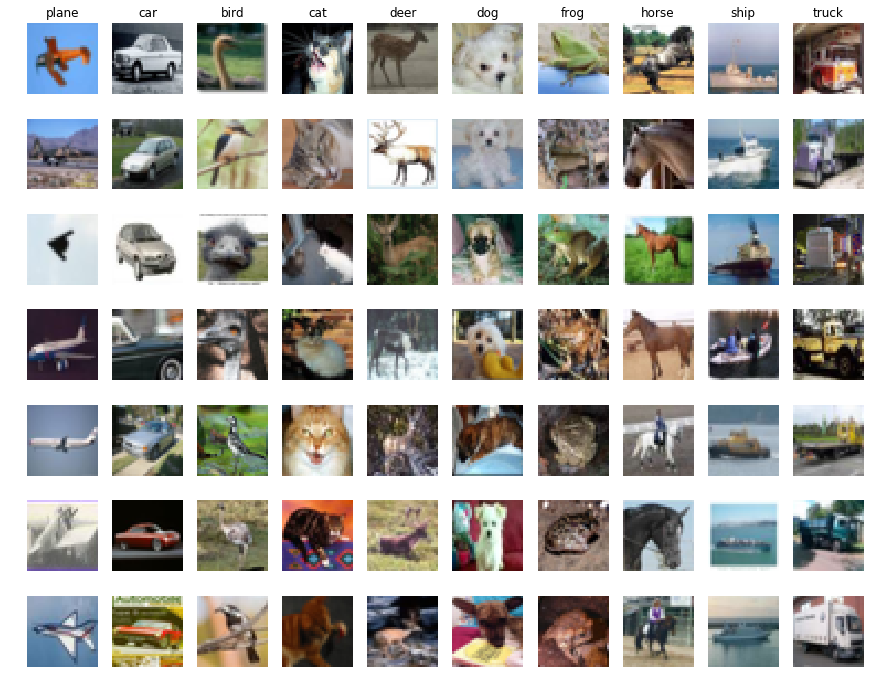

In [4]:
# 可视化一些样例数据
# 我们展示了每一类训练数据图像的几个例子。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# 将图像数据重新整理成行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [9]:
from DSVC.classifiers import KNearestNeighbor

# 创建一个KNN分类器的实例

KNN = KNearestNeighbor()
KNN.train(X_train, y_train)

In [17]:
dists_no_loop = KNN.cal_dists_no_loop(X_test)
dists_one_loop = KNN.cal_dists_one_loop(X_test)
dists_two_loop = KNN.cal_dists_two_loop(X_test)
diff1 = np.linalg.norm(dists_no_loop - dists_one_loop)
diff2 = np.linalg.norm(dists_no_loop - dists_two_loop)
print('无循环和单循环的区别: %f' % diff1)
print('无循环和双循环的区别: %f' % diff2)
if diff1 < 0.001 and diff2 < 0.001:
    print('距离一样')
else:
    print('距离不同')

无循环和单循环的区别: 0.000000
无循环和双循环的区别: 0.000000
距离一样


In [18]:
def time_func(f, *args):
    """
  用ARG调用函数f并返回执行所需的时间（以秒为单位）。
    """
    import time
    
    t_st = time.time()
    f(*args)
    t_ed = time.time()
    
    return t_ed - t_st

#无循环
no_loop_time = time_func(KNN.cal_dists_no_loop, X_test)
print('无循环时间: %f 秒' % no_loop_time)
one_loop_time = time_func(KNN.cal_dists_one_loop, X_test)
print('单循环时间: %f 秒' % one_loop_time)
two_loop_time = time_func(KNN.cal_dists_two_loop, X_test)
print('双循环时间: %f 秒' % two_loop_time)

无循环时间: 0.987842 秒


单循环时间: 126.782538 秒


双循环时间: 55.756981 秒


In [19]:
# k = 1
y_pred = KNN.predict(X_test, k=1)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('正确率 %d/%d: 即 %f' % (num_correct, X_test.shape[0], accuracy))

正确率 137/500: 即 0.274000


In [20]:
# k = 5
y_pred = KNN.predict(X_test, k=5)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('正确率 %d/%d: 即 %f' % (num_correct, X_test.shape[0], accuracy))

正确率 139/500: 即 0.278000


#交叉验证

In [21]:
num_folds = 5    # 将培训数据集拆分为5个部分
k_classes = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]    # 测试的k值

# 把训练数据分成几个部分
X_train_folds = []
y_train_folds = []
X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

# 正确率
k_accuracy = {}

for k in k_classes:
    accuracies = []
    #knn = KNearestNeighbor()
    for i in range(num_folds):
        Xtr = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        ytr = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        Xcv = X_train_folds[i]
        ycv = y_train_folds[i]
        KNN.train(Xtr, ytr)
        ycv_pred = KNN.predict(Xcv, k=k, num_loops=0)
        accuracy = np.mean(ycv_pred == ycv)
        accuracies.append(accuracy)
    k_accuracy[k] = accuracies

# Print the accuracy
for k in k_classes:
    for i in range(num_folds):
        print('k = %d, 数据集 = %d, 正确率: %f' % (k, i+1, k_accuracy[k][i]))

k = 1, 数据集 = 1, 正确率: 0.263000
k = 1, 数据集 = 2, 正确率: 0.257000
k = 1, 数据集 = 3, 正确率: 0.264000
k = 1, 数据集 = 4, 正确率: 0.278000
k = 1, 数据集 = 5, 正确率: 0.266000
k = 3, 数据集 = 1, 正确率: 0.239000
k = 3, 数据集 = 2, 正确率: 0.249000
k = 3, 数据集 = 3, 正确率: 0.240000
k = 3, 数据集 = 4, 正确率: 0.266000
k = 3, 数据集 = 5, 正确率: 0.254000
k = 5, 数据集 = 1, 正确率: 0.248000
k = 5, 数据集 = 2, 正确率: 0.266000
k = 5, 数据集 = 3, 正确率: 0.280000
k = 5, 数据集 = 4, 正确率: 0.292000
k = 5, 数据集 = 5, 正确率: 0.280000
k = 8, 数据集 = 1, 正确率: 0.262000
k = 8, 数据集 = 2, 正确率: 0.282000
k = 8, 数据集 = 3, 正确率: 0.273000
k = 8, 数据集 = 4, 正确率: 0.290000
k = 8, 数据集 = 5, 正确率: 0.273000
k = 10, 数据集 = 1, 正确率: 0.265000
k = 10, 数据集 = 2, 正确率: 0.296000
k = 10, 数据集 = 3, 正确率: 0.276000
k = 10, 数据集 = 4, 正确率: 0.284000
k = 10, 数据集 = 5, 正确率: 0.280000
k = 12, 数据集 = 1, 正确率: 0.260000
k = 12, 数据集 = 2, 正确率: 0.295000
k = 12, 数据集 = 3, 正确率: 0.279000
k = 12, 数据集 = 4, 正确率: 0.283000
k = 12, 数据集 = 5, 正确率: 0.280000
k = 15, 数据集 = 1, 正确率: 0.252000
k = 15, 数据集 = 2, 正确率: 0.289000
k = 15, 数据集 = 3, 正确率: 0.2780

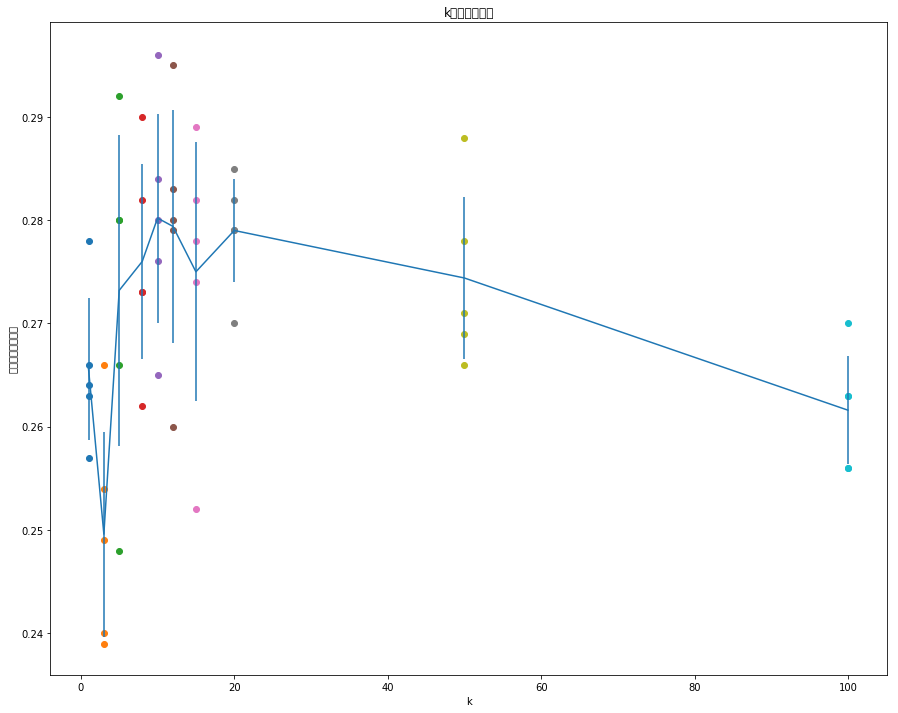

In [22]:
# 绘制交叉验证图
for k in k_classes:
    plt.scatter([k] * num_folds, k_accuracy[k])
# 绘制与标准偏差对应的误差列的趋势线
accuracies_mean = [np.mean(k_accuracy[k]) for k in k_accuracy]
accuracies_std = [np.std(k_accuracy[k]) for k in k_accuracy]
plt.errorbar(k_classes, accuracies_mean, yerr=accuracies_std)
plt.title('k值的交叉验证')
plt.xlabel('k')
plt.ylabel('交叉验证的正确率')
plt.show()

In [23]:
# 选择最优k值
best_k = k_classes[np.argmax(accuracies_mean)]
# 使用最优K值，并在测试数据上进行测试
KNN = KNearestNeighbor()
KNN.train(X_train, y_train)
y_pred = KNN.predict(X_test, k=best_k, num_loops=0)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('正确率 %d/%d: 即 %f' % (num_correct, X_test.shape[0], accuracy))

正确率 141/500: 即 0.282000
